In [1]:
def calculate(x):
    return x*x

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

inputs = np.arange(-0.5,0.6,0.1)
inputs

array([-5.00000000e-01, -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
       -1.00000000e-01, -1.11022302e-16,  1.00000000e-01,  2.00000000e-01,
        3.00000000e-01,  4.00000000e-01,  5.00000000e-01])

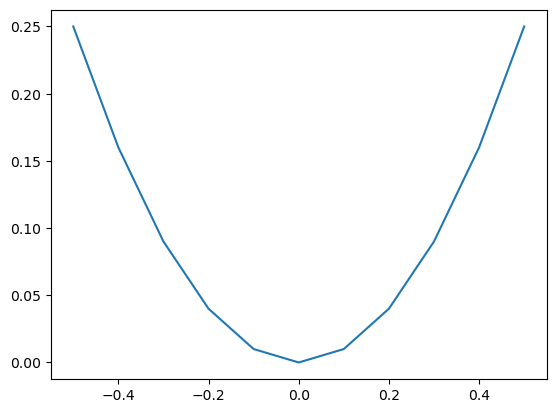

In [3]:
outputs = [calculate(x) for x in inputs]
plt.plot(inputs,outputs)
plt.show()

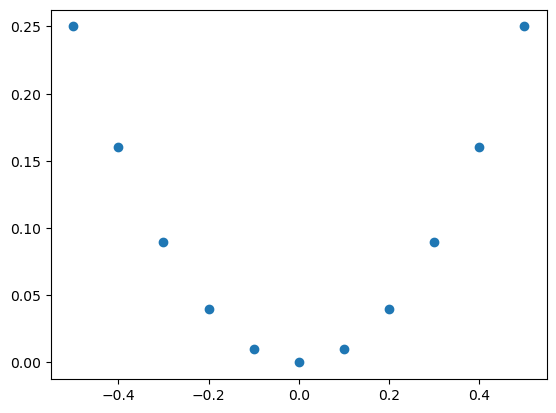

In [4]:
plt.scatter(inputs,outputs)

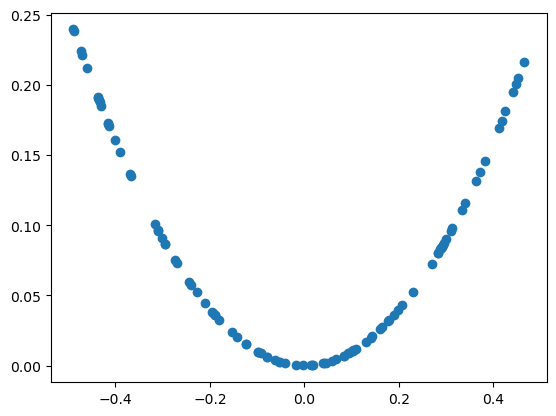

In [5]:
# generate random samples
def generate_samples(n=100):
    
    X1 = np.random.rand(n) - 0.5
#     print(X1)
    X2 = X1 * X1
#     print(X2)
    X1 = X1.reshape(n,1)
    X2 = X2.reshape(n,1)
    return np.hstack((X1,X2))

data = generate_samples()

plt.scatter(data[:,0],data[:,1])
plt.show()

### Defining a discriminator model

In [6]:
import torch
import torch.nn as nn

In [7]:
def define_discriminator(n_inputs=2):
    model = nn.Sequential()
    model.add_module(nn.Dens)

In [8]:
class Discriminator(nn.Module):
    def __init__(self,n_inputs=2):
        super(Discriminator,self).__init__()
        self.fc1 = nn.Linear(n_inputs,25)
        self.fc2 = nn.Linear(25,1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.he_init = nn.init.kaiming_uniform_
        
    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [9]:
disc_model = Discriminator(n_inputs=2)

In [10]:
# initializing the weights using He initialization
for m in disc_model.modules():
    if isinstance(m,nn.Linear):
        nn.init.kaiming_uniform_(m.weight,nonlinearity='relu')

In [11]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(disc_model.parameters(),lr=0.001)
print(disc_model)

Discriminator(
  (fc1): Linear(in_features=2, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [12]:
## training the model with real examples with class label of one and randomly generated samples with class label of zero
def generate_real_sampels(n):
    X1 = torch.rand(n) - 0.5
    
    X2 = X1*X1
    X1 = X1.reshape(n,1)
    X2 = X2.reshape(n,1)
    X = torch.cat((X1,X2),dim=1)
    y = torch.ones((n,1))
    return X,y

In [13]:
X,y = generate_real_sampels(20)
print(X)
print(y)

tensor([[-6.3795e-02,  4.0698e-03],
        [-2.2096e-02,  4.8822e-04],
        [-1.3897e-01,  1.9314e-02],
        [-2.3194e-02,  5.3794e-04],
        [-1.5588e-02,  2.4298e-04],
        [-2.7322e-01,  7.4648e-02],
        [ 1.6430e-01,  2.6994e-02],
        [-3.0752e-01,  9.4570e-02],
        [ 3.0384e-01,  9.2320e-02],
        [-6.9775e-02,  4.8685e-03],
        [ 8.5701e-02,  7.3446e-03],
        [ 1.8706e-01,  3.4990e-02],
        [-4.3421e-01,  1.8854e-01],
        [-3.4054e-01,  1.1597e-01],
        [-1.2517e-01,  1.5668e-02],
        [-3.3036e-01,  1.0914e-01],
        [ 2.8166e-03,  7.9333e-06],
        [-3.0576e-01,  9.3486e-02],
        [-1.9203e-02,  3.6875e-04],
        [ 2.5266e-01,  6.3837e-02]])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]

In [14]:
def generate_fake_samples(n):
    #generate inputs in [-1,1]
    X1 = -1 + torch.rand(n) *2
    X2 = -1 + torch.rand(n) *2
    X1 = X1.reshape(n,1)
    X2 = X2.reshape(n,1)
    X = torch.cat((X1,X2),dim=1)
#     X = np.hstack((X1,X2))
    y = torch.zeros((n,1))
    return X,y

In [15]:
num_epochs = 1000
num_batch = 128
half_batch = int(num_batch / 2)

In [16]:
def train_on_batch(model,optimizer,criterion,inputs,labels):
    model.train()
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    return loss.item()

In [17]:
def evaluate_model(model,inputs,labels):
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        accuracy = (predicted == labels).float().mean().item()
    return accuracy

In [18]:
def train_discriminator(model,n_epochs=1000,n_batch = 128):
    half_batch = int(n_batch/2)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    
    for epoch in range(n_epochs):
        X_real,y_real = generate_real_sampels(half_batch)
        real_loss = train_on_batch(model,optimizer,criterion,X_real,y_real)
        
        # generate fake samples
        X_fake,y_fake = generate_fake_samples(half_batch)
        
        fake_loss = train_on_batch(model,optimizer,criterion,X_fake,y_fake)
        
        acc_real = evaluate_model(model,X_real,y_real)
        acc_fake = evaluate_model(model,X_fake,y_fake)
        print(f'Epch {epoch +1}/{n_epochs},Real accuracy: {acc_real:.4f}, Fake accuracy: {acc_fake:.4f}')

In [19]:
model = Discriminator(n_inputs=2)

In [20]:
train_discriminator(model,n_epochs=1000,n_batch=128)

Epch 1/1000,Real accuracy: 0.0000, Fake accuracy: 0.8125
Epch 2/1000,Real accuracy: 0.0000, Fake accuracy: 0.7500
Epch 3/1000,Real accuracy: 0.0000, Fake accuracy: 0.8594
Epch 4/1000,Real accuracy: 0.0000, Fake accuracy: 0.8281
Epch 5/1000,Real accuracy: 0.0000, Fake accuracy: 0.7812
Epch 6/1000,Real accuracy: 0.0000, Fake accuracy: 0.8281
Epch 7/1000,Real accuracy: 0.0000, Fake accuracy: 0.7969
Epch 8/1000,Real accuracy: 0.0000, Fake accuracy: 0.8594
Epch 9/1000,Real accuracy: 0.0000, Fake accuracy: 0.7344
Epch 10/1000,Real accuracy: 0.0000, Fake accuracy: 0.6562
Epch 11/1000,Real accuracy: 0.0000, Fake accuracy: 0.7812
Epch 12/1000,Real accuracy: 0.0000, Fake accuracy: 0.8125
Epch 13/1000,Real accuracy: 0.0000, Fake accuracy: 0.7969
Epch 14/1000,Real accuracy: 0.0000, Fake accuracy: 0.7969
Epch 15/1000,Real accuracy: 0.0000, Fake accuracy: 0.8594
Epch 16/1000,Real accuracy: 0.0000, Fake accuracy: 0.7656
Epch 17/1000,Real accuracy: 0.0000, Fake accuracy: 0.8594
Epch 18/1000,Real accur

Epch 202/1000,Real accuracy: 0.6250, Fake accuracy: 0.9375
Epch 203/1000,Real accuracy: 0.5938, Fake accuracy: 0.9531
Epch 204/1000,Real accuracy: 0.6875, Fake accuracy: 0.9375
Epch 205/1000,Real accuracy: 0.7500, Fake accuracy: 0.9531
Epch 206/1000,Real accuracy: 0.6875, Fake accuracy: 0.9531
Epch 207/1000,Real accuracy: 0.7344, Fake accuracy: 0.9219
Epch 208/1000,Real accuracy: 0.7344, Fake accuracy: 0.8906
Epch 209/1000,Real accuracy: 0.7500, Fake accuracy: 0.9219
Epch 210/1000,Real accuracy: 0.7031, Fake accuracy: 0.8906
Epch 211/1000,Real accuracy: 0.7969, Fake accuracy: 0.9531
Epch 212/1000,Real accuracy: 0.8125, Fake accuracy: 0.8906
Epch 213/1000,Real accuracy: 0.6719, Fake accuracy: 0.9062
Epch 214/1000,Real accuracy: 0.7500, Fake accuracy: 0.9219
Epch 215/1000,Real accuracy: 0.7500, Fake accuracy: 0.9375
Epch 216/1000,Real accuracy: 0.7188, Fake accuracy: 0.9375
Epch 217/1000,Real accuracy: 0.6719, Fake accuracy: 1.0000
Epch 218/1000,Real accuracy: 0.7344, Fake accuracy: 0.90

Epch 410/1000,Real accuracy: 0.9375, Fake accuracy: 0.8750
Epch 411/1000,Real accuracy: 0.9375, Fake accuracy: 0.8594
Epch 412/1000,Real accuracy: 0.9062, Fake accuracy: 0.8906
Epch 413/1000,Real accuracy: 0.9531, Fake accuracy: 0.9219
Epch 414/1000,Real accuracy: 0.8906, Fake accuracy: 0.9062
Epch 415/1000,Real accuracy: 0.9688, Fake accuracy: 0.9531
Epch 416/1000,Real accuracy: 0.9688, Fake accuracy: 0.9062
Epch 417/1000,Real accuracy: 0.9531, Fake accuracy: 0.9062
Epch 418/1000,Real accuracy: 0.9375, Fake accuracy: 0.8438
Epch 419/1000,Real accuracy: 0.9219, Fake accuracy: 0.9219
Epch 420/1000,Real accuracy: 0.9844, Fake accuracy: 0.9219
Epch 421/1000,Real accuracy: 0.9844, Fake accuracy: 0.8750
Epch 422/1000,Real accuracy: 0.9688, Fake accuracy: 0.8906
Epch 423/1000,Real accuracy: 0.9531, Fake accuracy: 0.8750
Epch 424/1000,Real accuracy: 0.9844, Fake accuracy: 0.8438
Epch 425/1000,Real accuracy: 0.9688, Fake accuracy: 0.8750
Epch 426/1000,Real accuracy: 0.9531, Fake accuracy: 0.89

Epch 622/1000,Real accuracy: 1.0000, Fake accuracy: 0.7656
Epch 623/1000,Real accuracy: 1.0000, Fake accuracy: 0.9219
Epch 624/1000,Real accuracy: 1.0000, Fake accuracy: 0.8906
Epch 625/1000,Real accuracy: 1.0000, Fake accuracy: 0.8281
Epch 626/1000,Real accuracy: 1.0000, Fake accuracy: 0.8281
Epch 627/1000,Real accuracy: 1.0000, Fake accuracy: 0.9375
Epch 628/1000,Real accuracy: 1.0000, Fake accuracy: 0.8594
Epch 629/1000,Real accuracy: 1.0000, Fake accuracy: 0.8438
Epch 630/1000,Real accuracy: 1.0000, Fake accuracy: 0.8594
Epch 631/1000,Real accuracy: 1.0000, Fake accuracy: 0.8750
Epch 632/1000,Real accuracy: 1.0000, Fake accuracy: 0.9219
Epch 633/1000,Real accuracy: 1.0000, Fake accuracy: 0.8750
Epch 634/1000,Real accuracy: 1.0000, Fake accuracy: 0.8750
Epch 635/1000,Real accuracy: 1.0000, Fake accuracy: 0.7969
Epch 636/1000,Real accuracy: 1.0000, Fake accuracy: 0.7969
Epch 637/1000,Real accuracy: 1.0000, Fake accuracy: 0.9219
Epch 638/1000,Real accuracy: 1.0000, Fake accuracy: 0.89

Epch 835/1000,Real accuracy: 1.0000, Fake accuracy: 0.9688
Epch 836/1000,Real accuracy: 1.0000, Fake accuracy: 0.7656
Epch 837/1000,Real accuracy: 1.0000, Fake accuracy: 0.7969
Epch 838/1000,Real accuracy: 1.0000, Fake accuracy: 0.9062
Epch 839/1000,Real accuracy: 1.0000, Fake accuracy: 0.8750
Epch 840/1000,Real accuracy: 1.0000, Fake accuracy: 0.8125
Epch 841/1000,Real accuracy: 1.0000, Fake accuracy: 0.8750
Epch 842/1000,Real accuracy: 1.0000, Fake accuracy: 0.8750
Epch 843/1000,Real accuracy: 1.0000, Fake accuracy: 0.8750
Epch 844/1000,Real accuracy: 1.0000, Fake accuracy: 0.8438
Epch 845/1000,Real accuracy: 1.0000, Fake accuracy: 0.8281
Epch 846/1000,Real accuracy: 1.0000, Fake accuracy: 0.9062
Epch 847/1000,Real accuracy: 1.0000, Fake accuracy: 0.9375
Epch 848/1000,Real accuracy: 1.0000, Fake accuracy: 0.8750
Epch 849/1000,Real accuracy: 1.0000, Fake accuracy: 0.8906
Epch 850/1000,Real accuracy: 1.0000, Fake accuracy: 0.8750
Epch 851/1000,Real accuracy: 1.0000, Fake accuracy: 0.82

### Defining a Generator Model

In [21]:
class Generator(nn.Module):
    def __init__(self,latent_dim,n_outputs=2):
        super(Generator,self).__init__()
        self.fc1 = nn.Linear(latent_dim,15)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(15,n_outputs)
        self.latent_dim = latent_dim
        
        nn.init.kaiming_uniform_(self.fc1.weight,nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight,nonlinearity='linear')
        
        
    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x    


In [22]:
gen_model = Generator(5)
print(gen_model)

Generator(
  (fc1): Linear(in_features=5, out_features=15, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=15, out_features=2, bias=True)
)


In [23]:
## generating random points in the latent space
def generate_latent_points(latent_dim,n):
    x_input = torch.randn(latent_dim*n)
    x_input = x_input.reshape(n,latent_dim)
    return x_input

In [38]:
## using the generator to generate n fake samples and plot the results
def generate_fake_samples(generator,latent_dim,n):
    generator.eval()
    with torch.no_grad():
        x_input = generate_latent_points(latent_dim,n)
        X = generator(x_input)
    return X
#         plt.scatter(X[:,0],X[:,1])
#         plt.show()

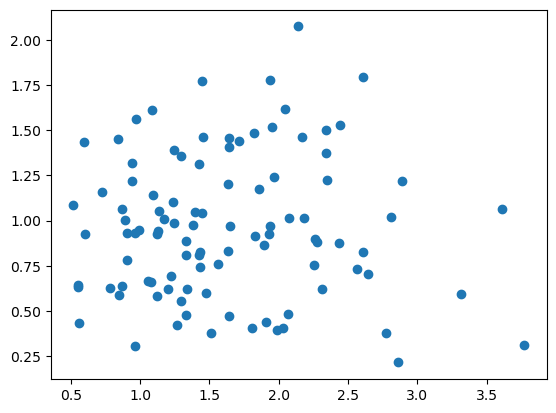

In [26]:
latent_dim = 5
gen_model = Generator(latent_dim)
generate_fake_samples(gen_model,latent_dim,100)

### Training the Generator Model

In [27]:
class GAN(nn.Module):
    def __init__(self,generator,discriminator):
        super(GAN,self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        
    def forward(self,x):
        generated_data = self.generator(x)
        validity = self.discriminator(generated_data)
        return validity

In [28]:
latent_dim = 100
generator = Generator(latent_dim)
discriminator = Discriminator()

gan = GAN(generator=generator,discriminator=discriminator)

#Loss function and optimizer
criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(),lr=0.0002)
optimizer_d = torch.optim.Adam(discriminator.parameters(),lr=0.0002)



In [ ]:
def train_gan(generator,discriminator,criterion,optimizer_g,optimizer_d,latent_dim,epochs,batch_size):
    for epoch in range(epochs):
        for _ in range(batch_size):
            # training discriminator
            discriminator.train()
            optimizer_d.zero_grad()
            
            real_data,real_labels = generate_real_sampels(batch_size)
            latent_points = generate_latent_points(latent_dim,batch_size)
            fake_data,fake_labels = generate_fake_samples(batch_size)
            
            real_loss = criterion(discriminator(real_data),real_labels)
            fake_loss = criterion(discriminator(fake_data),fake_labels)
            
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_d.step()
            
            #Train Generator
            for param in discriminator.parameters():
                param.requires_grad = False
                
            generator.train()
            optimizer_g.zero_grad()
            
            latent_points = generate_latent_points(latent_dim,batch_size)
            fake_data = generator(latent_points)
            
            
            
            

In [31]:
latent_dim = 5
discriminator = Discriminator()
generator = Generator(latent_dim=latent_dim)

gan = GAN(generator=generator,discriminator=discriminator)


In [32]:
print(gan)

GAN(
  (generator): Generator(
    (fc1): Linear(in_features=5, out_features=15, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=15, out_features=2, bias=True)
  )
  (discriminator): Discriminator(
    (fc1): Linear(in_features=2, out_features=25, bias=True)
    (fc2): Linear(in_features=25, out_features=1, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
)


In [ ]:
def train_gan(gan_model,latent_dim,n_epochs=1000,n_batch=128,device='cpu'):
        #Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer_g = torch.optim.Adam(generator.parameters(),lr=0.0002)
    optimizer_d = torch.optim.Adam(discriminator.parameters(),lr=0.0002)

    generator.to(device)
    for epoch in range(n_epochs):
        x_gan = generate_latent_points(latent_dim,n_batch)
        y_gan = torch.ones((n_batch,1))
        

In [33]:


# Define the training function
def train_gan(generator, discriminator, gan_model, latent_dim, n_epochs=10000, n_batch=128, device='cpu'):
    # Define loss function and optimizers
    criterion = nn.BCELoss()
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0002)
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

    # Move models to the specified device
    generator.to(device)
    discriminator.to(device)
    gan_model.to(device)

    for epoch in range(n_epochs):
        # Prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch).to(device)
        # Create inverted labels for the fake samples
        y_gan = torch.ones((n_batch, 1), device=device)
        
        # Train generator via discriminator's error
        generator.train()
        optimizer_g.zero_grad()
        y_pred = gan_model(x_gan)
        g_loss = criterion(y_pred, y_gan)
        g_loss.backward()
        optimizer_g.step()

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}/{n_epochs}, Generator Loss: {g_loss.item():.4f}')

# Example usage:
latent_dim = 5
generator = Generator(latent_dim)
discriminator = Discriminator()
gan_model = GAN(generator, discriminator)

# Train the GAN model
train_gan(generator, discriminator, gan_model, latent_dim)


Epoch 0/10000, Generator Loss: 0.5401
Epoch 1000/10000, Generator Loss: 0.3146
Epoch 2000/10000, Generator Loss: 0.1363
Epoch 3000/10000, Generator Loss: 0.0638
Epoch 4000/10000, Generator Loss: 0.0273
Epoch 5000/10000, Generator Loss: 0.0111
Epoch 6000/10000, Generator Loss: 0.0058
Epoch 7000/10000, Generator Loss: 0.0037
Epoch 8000/10000, Generator Loss: 0.0020
Epoch 9000/10000, Generator Loss: 0.0012


In [40]:
### complete training functin for training the generator and discriminator

def train(g_model,d_model,gan_model,latent_dim,n_epochs=10000,n_batch=128):
    half_batch = int(n_batch/2)
    for i in range(n_epochs):
        x_real,y_real = generate_real_sampels(half_batch)
        x_fake,y_fake = generate_fake_samples(g_model,latent_dim,half_batch)
        
        train_discriminator(d_model,n_epochs=n_epochs)
        
        x_gan = generate_latent_points(latent_dim,n_batch)
        y_gan = torch.ones((n_batch,1))
        train_gan(g_model,d_model,gan_model,latent_dim=latent_dim)
        
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}/{n_epochs}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')
        
            